In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # adjust for your machine and availability
import jax

os.listdir()
os.chdir("..")
from src.c3po.model.model import C3PO
from src.c3po.toy_model_generators.hmm import generate_hmm_spike_train
from src.c3po.toy_model_generators.phase import (
    generate_periodic_spike_train_multimodal,
    generate_waveform_features,
)

import numpy as np
import scipy.signal


def smooth(data, n=5, sigma=None, hamming=False):
    """smooths data with gaussian kernel of size n"""
    if n % 2 == 0:
        n += 1  # make sure n is odd
    if sigma is None:
        sigma = n / 2
    kernel = gkern(n, sigma)[:, None]
    if hamming:
        n = sigma
        kernel = np.ones((sigma, 1)) / sigma
    if len(data.shape) == 1:
        pad = np.ones(((n - 1) // 2, 1))
        return np.squeeze(
            scipy.signal.convolve2d(
                np.concatenate(
                    [pad * data[:, None][0], data[:, None], pad * data[:, None][-1]],
                    axis=0,
                ),
                kernel,
                mode="valid",
            )
        )
    else:
        pad = np.ones(((n - 1) // 2, data.shape[1]))
        return scipy.signal.convolve2d(
            np.concatenate([pad * data[0], data, pad * data[-1]], axis=0),
            kernel,
            mode="valid",
        )


def gkern(l: int = 5, sig: float = 1.0):
    """
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    return gauss / np.sum(gauss)
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [2]:
latent_period = 3
noise_scale = 0.1
t_max = 5000
n_units = 64
n_channels = 128
max_wait_update = 0.3

mark_ids, mark_times, marks, template_waveforms, tuning_curves = (
    generate_periodic_spike_train_multimodal(
        latent_period=latent_period,
        noise_scale=noise_scale,
        t_max=t_max,
        n_units=n_units,
        n_channels=n_channels,
        max_wait_update=max_wait_update,
    )
)
theta_bins = np.linspace(0, 2 * np.pi, tuning_curves.shape[0])
t = np.arange(0, t_max, 0.001)
theta = np.mod(t, latent_period) / latent_period * 2 * np.pi

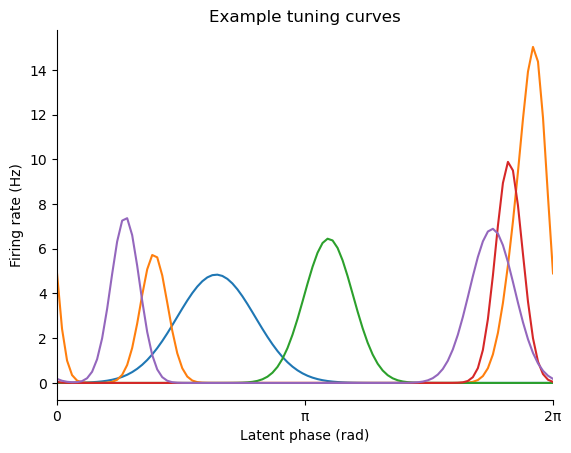

In [3]:
import matplotlib.pyplot as plt

plt.plot(
    theta_bins,
    tuning_curves[:, np.random.choice(n_units, 5)],
)
plt.xlabel("Latent phase (rad)")
plt.ylabel("Firing rate (Hz)")

plt.title("Example tuning curves")
plt.xlim(0, 2 * np.pi)
ax = plt.gca()
ax.set_xticks([0, np.pi, 2 * np.pi])
ax.set_xticklabels(["0", "π", "2π"])
ax.spines[["top", "right"]].set_visible(False)

In [5]:
# n_noise_units = 32
# for i in range(n_units - n_noise_units, n_units):
#     ind = np.where(mark_ids == i)[0]
#     new_times = np.random.uniform(0, t_max, size=len(ind))
#     mark_times[ind] = new_times

# # sort spikes by time
# ind = np.argsort(mark_times)
# mark_times = mark_times[ind]
# mark_ids = mark_ids[ind]
# marks = marks[ind]

In [5]:
# n_noise_units = 4

# noise_template_waveforms = generate_waveform_features(
#     n_channels=n_channels, n_units=n_noise_units
# )

# noise_times = []
# noise_ids = []
# noise_marks = []
# for i in range(n_noise_units):
#     rate_hz = np.random.uniform(0.5, 2.0)
#     n_spikes = np.random.poisson(rate_hz * np.max(mark_times))
#     times_ = np.random.uniform(0, np.max(mark_times), size=n_spikes)
#     noise_times.extend(times_)
#     noise_ids.extend(np.ones_like(times_) * (i + mark_ids.max() + 1))
#     noise_marks.extend(
#         np.ones((n_spikes, n_channels)) * noise_template_waveforms[i]
#         + np.random.normal(0, noise_scale, size=(n_spikes, n_channels))
#     )

# merged_marks = np.vstack([marks, noise_marks])
# merged_times = np.hstack([mark_times, noise_times])
# merged_ids = np.hstack([mark_ids, noise_ids])

# sort_idx = np.argsort(merged_times)
# merged_times = merged_times[sort_idx]
# merged_ids = merged_ids[sort_idx].astype(int)
# merged_marks = merged_marks[sort_idx]

# Build Model

In [ ]:
# prep data for model
from src.c3po.model.util import prep_training_data

delta_t = np.diff(mark_times)[None, ...]
x = marks[1:][None, ...]

sample_length = 2000
x_train, delta_t_train = prep_training_data(x, delta_t, sample_length)
i = sample_length

# hyperparams
latent_dim = 32
context_dim = 16
encoder_widths = [64, 32, 16, 8]

n_neg_samples = 16
encoder_args = dict(encoder_model="simple", widths=encoder_widths)
dilations = [
    1,
    2,
    4,
    8,
]
kernels = [8, 8, 16, 16]
# dilations = dilations * 2
# kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=2,
    smoothing_decay=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinear",
)

# rate_args = dict(rate_model="sharedSpace")


# model = C3PO(encoder_args, context_args, rate_args, latent_dim, context_dim, n_neg_samples)
model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    return_embeddings_in_call=True,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(0), x, delta_t, rand_key)
run_model = jax.jit(model.apply)
x_train.shape

3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
16000

(396, 2000, 128)

In [29]:
# update n-neg
n_neg = 128
model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    return_embeddings_in_call=True,
)

# Train Model

In [52]:
# import optax
# from tqdm import tqdm
# from src.c3po.model.model import loss
# import jax.numpy as jnp

# learning_rate = 3e-4
# batch_size = 16

# l1_penalty = 1e0

# def training_loss_fun(params, x, delta_t, rand_key):
#     pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
#     contrastive_loss =  model.contrastive_loss(
#         pos_params,
#         neg_params,
#         delta_t,
#         z[:, 1:],
#         neg_z,
#     )
#     return contrastive_loss + l1_penalty *jnp.sum(jnp.abs(c), axis=-1).mean()


# loss_grad_fn = jax.value_and_grad(training_loss_fun)


# optimizer = optax.chain(
#     # optax.clip_by_global_norm(1.0),
#     optax.adam(learning_rate),
# )

# # Initialize parameters of the model + optimizer.
# opt_state = optimizer.init(params)
# # Run training loop.
# tracked_loss = []
# with tqdm() as pbar:
#     for i in range(1000):
#         ind = np.arange(x_train.shape[0])
#         np.random.shuffle(ind)
#         epoch_loss = []
#         j = 0
#         while j < x_train.shape[0]:
#             # Perform one gradient update.
#             rand_key, _ = jax.random.split(rand_key)
#             batch_inds = ind[j : j + batch_size]
#             loss_val, grads = loss_grad_fn(
#                 params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
#             )
#             epoch_loss.append(loss_val)
#             updates, opt_state = optimizer.update(grads, opt_state)
#             params = optax.apply_updates(params, updates)
#             j += batch_size
#         tracked_loss.append(np.mean(epoch_loss))
#         pbar.update(1)
#         pbar.set_description(f"loss: {tracked_loss[-1]:.4f}")
import optax
from tqdm import tqdm
from src.c3po.model.model import loss
import jax.numpy as jnp

learning_rate = 1e-3
batch_size = 128


def epoch_penalty_schedule(epoch):
    return 0

    l1_max = 0
    l1_min = -3
    xx = epoch
    yy = (np.tanh((xx - 50) / 30) + 1) / 2
    yy = yy * (l1_max - l1_min) + l1_min
    yy = 10 ** (yy)
    return yy


def training_loss_fun(params, x, delta_t, rand_key, l1_penalty=0, check=False):
    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    # print(c.shape)
    if check and np.var(c[0, :, 0]) < 1e-4:
        raise ValueError("Collapsed context")
    # contrastive_loss = model.contrastive_loss(
    #     pos_params,
    #     neg_params,
    #     delta_t,
    #     z[:, 1:],
    #     neg_z,
    # )
    # if l1_penalty == 0:
    #     return contrastive_loss
    # return contrastive_loss + l1_penalty * jnp.sum(jnp.abs(c), axis=-1).mean()
    loss = model.mle_loss(
        pos_params,
        neg_params,
        delta_t,
        sample_step=1,  # None,
        n_emission_sources=3,
        rand_key=None,
        prior_params=None,
    )
    return loss


loss_grad_fn = jax.value_and_grad(training_loss_fun)


optimizer = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate),
)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)
# Run training loop.
tracked_loss = []
with tqdm() as pbar:
    for i in range(1000):
        ind = np.arange(x_train.shape[0])
        np.random.shuffle(ind)
        epoch_loss = []
        j = 0
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            loss_val, grads = loss_grad_fn(
                params,
                x_train[batch_inds],
                delta_t_train[batch_inds],
                rand_key,
                epoch_penalty_schedule(i),
                check=(i > 5),
            )
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            j += batch_size
        tracked_loss.append(np.mean(epoch_loss))
        pbar.update(1)
        pbar.set_description(f"loss: {tracked_loss[-1]:.4f}")

0it [00:00, ?it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -0.2168: : 1it [00:09,  9.66s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -0.7766: : 2it [00:10,  4.52s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -1.2726: : 3it [00:11,  2.86s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -1.6074: : 4it [00:12,  2.08s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -1.8030: : 5it [00:13,  1.65s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -1.9161: : 6it [00:14,  1.40s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.0143: : 7it [00:15,  1.25s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.0948: : 8it [00:16,  1.16s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.1659: : 9it [00:16,  1.09s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.2234: : 10it [00:17,  1.05s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.2831: : 11it [00:18,  1.02s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.3312: : 12it [00:19,  1.01it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.3687: : 13it [00:20,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.3976: : 14it [00:21,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.4219: : 15it [00:22,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.4531: : 16it [00:23,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.4844: : 17it [00:24,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.5152: : 18it [00:25,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.5446: : 19it [00:26,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.4868: : 20it [00:27,  1.03it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.4944: : 21it [00:28,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.5436: : 22it [00:29,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.5886: : 23it [00:30,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6071: : 24it [00:31,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6356: : 25it [00:32,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6532: : 26it [00:33,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6655: : 27it [00:34,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6832: : 28it [00:35,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6957: : 29it [00:36,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7098: : 30it [00:36,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7234: : 31it [00:37,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.7325: : 32it [00:38,  1.02it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.7411: : 33it [00:39,  1.02it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.7507: : 34it [00:40,  1.01it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6548: : 35it [00:41,  1.01it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.3798: : 36it [00:42,  1.01it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.4691: : 37it [00:44,  1.01s/it]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.5174: : 38it [00:44,  1.01it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6186: : 39it [00:45,  1.00s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6592: : 40it [00:46,  1.01it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.6929: : 41it [00:47,  1.02it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7155: : 42it [00:48,  1.02it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7331: : 43it [00:49,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.7472: : 44it [00:50,  1.02it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7574: : 45it [00:51,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7672: : 46it [00:52,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7728: : 47it [00:53,  1.02it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7858: : 48it [00:54,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7936: : 49it [00:55,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.7994: : 50it [00:56,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8174: : 51it [00:57,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8282: : 52it [00:58,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8364: : 53it [00:59,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.8536: : 54it [01:00,  1.03it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8653: : 55it [01:01,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8727: : 56it [01:02,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8836: : 57it [01:03,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.8946: : 58it [01:04,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9047: : 59it [01:05,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9057: : 60it [01:06,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9145: : 61it [01:07,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9206: : 62it [01:08,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9244: : 63it [01:09,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9069: : 64it [01:09,  1.06it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9331: : 65it [01:10,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9355: : 66it [01:11,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9444: : 67it [01:12,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.9486: : 68it [01:13,  1.03it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9588: : 69it [01:14,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9598: : 70it [01:15,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -2.9658: : 71it [01:16,  1.03it/s]

neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9680: : 72it [01:17,  1.02it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9765: : 73it [01:18,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9844: : 74it [01:19,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9787: : 75it [01:20,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9431: : 76it [01:21,  1.04it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9485: : 77it [01:22,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9748: : 78it [01:23,  1.03it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9762: : 79it [01:24,  1.05it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -2.9938: : 80it [01:25,  1.08it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0005: : 81it [01:26,  1.09it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0044: : 82it [01:27,  1.09it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0112: : 83it [01:28,  1.10it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0199: : 84it [01:28,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0245: : 85it [01:29,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0373: : 86it [01:30,  1.09it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0398: : 87it [01:31,  1.10it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0478: : 88it [01:32,  1.10it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0506: : 89it [01:33,  1.10it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0552: : 90it [01:34,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0622: : 91it [01:35,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0648: : 92it [01:36,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0765: : 93it [01:37,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0782: : 94it [01:37,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0780: : 95it [01:38,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0609: : 96it [01:39,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0864: : 97it [01:40,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0946: : 98it [01:41,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0994: : 99it [01:42,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1016: : 100it [01:43,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1077: : 101it [01:44,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1190: : 102it [01:45,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1230: : 103it [01:46,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1213: : 104it [01:46,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1355: : 105it [01:47,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1430: : 106it [01:48,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1415: : 107it [01:49,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1284: : 108it [01:50,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.0966: : 109it [01:51,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1046: : 110it [01:52,  1.10it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1244: : 111it [01:53,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1518: : 112it [01:54,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1605: : 113it [01:55,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1800: : 114it [01:55,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.1942: : 115it [01:56,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2035: : 116it [01:57,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2146: : 117it [01:58,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2270: : 118it [01:59,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2336: : 119it [02:00,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2465: : 120it [02:01,  1.13it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2561: : 121it [02:02,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2649: : 122it [02:03,  1.13it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2685: : 123it [02:03,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2784: : 124it [02:04,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2907: : 125it [02:05,  1.12it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2957: : 126it [02:06,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (12, 1998)
pos_survival_term (12, 0, 1998)
hazard_term (12, 1, 1998)


loss: -3.2921: : 127it [02:07,  1.11it/s]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)
neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


loss: -3.2921: : 127it [02:08,  1.01s/it]

neg_survival_term (128, 1998)
pos_survival_term (128, 0, 1998)
hazard_term (128, 1, 1998)


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

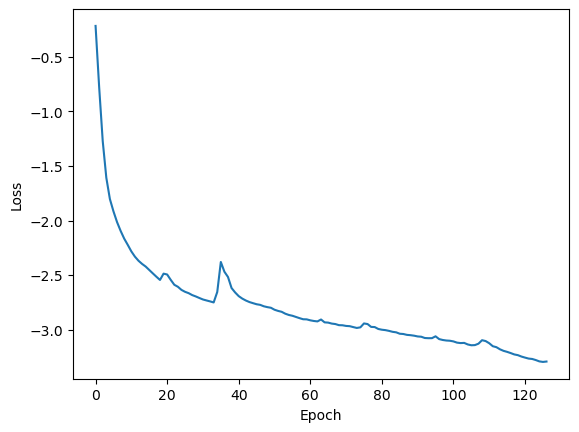

In [53]:
epoch = np.arange(len(tracked_loss))
plt.plot(epoch, tracked_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Train V2

In [197]:
from src.c3po.model.model import loss

distribution = "poisson"
predicted_sequence_length = 1


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    # run_model = jax.jit(model.apply)
    run_model = model.apply

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
        return model.contrastive_loss(
            pos_params,
            neg_params,
            delta_t,
            z[:, predicted_sequence_length:],
            neg_z,
        )

    return jax.value_and_grad(training_loss_fun)


def training_loss_fun(params, x, delta_t, rand_key):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = model.apply

    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, predicted_sequence_length:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)

In [198]:
from tqdm import tqdm
import optax

learning_rate = 1e-3
batch_size = 16
n_neg = 8

print(loss_grad_fn(params, x_train[:10], delta_t_train[:10], rand_key)[0])
import optax

optimizer = optax.chain(
    optax.adam(learning_rate),
)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)


tracked_loss = []
buffer = 5
for i in range(5000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    with tqdm(
        total=x_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        prev_params = params.copy()  # store params from end of previous epoch
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            if len(batch_inds) < batch_size:
                break
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            if not np.isfinite(loss_val):
                params = prev_params.copy()
                raise ValueError("Loss is not finite")
            # print(loss_val)
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            j += batch_size

            pbar.update(batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )
            # break
    tracked_loss.append(np.mean(epoch_loss))
    # if i < 10:
    #     continue
    buffer -= 1
    if (np.mean(tracked_loss[-5:-1]) < tracked_loss[-1] * 1.01) and buffer <= 0:
        print("HI")
        if n_neg < 128:
            n_neg *= 2
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5
        elif batch_size > 8:
            n_neg = 16
            batch_size = int(batch_size // 2)
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5

KeyboardInterrupt: 

# Analyze results

In [7]:
from src.c3po.analysis.analysis import C3poAnalysis

model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    sample_params=None,
)
analysis = C3poAnalysis(
    model=model,
    model_args=model_args,
    params=params,
)

In [8]:
analysis.embed_data(x, delta_t, first_mark_time=0, chunk_size=5000, delta_t_units="s")
analysis.fit_context_pca()
t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()

 99%|█████████▉| 395000/397427 [00:01<00:00, 213156.87it/s]


### Example trace

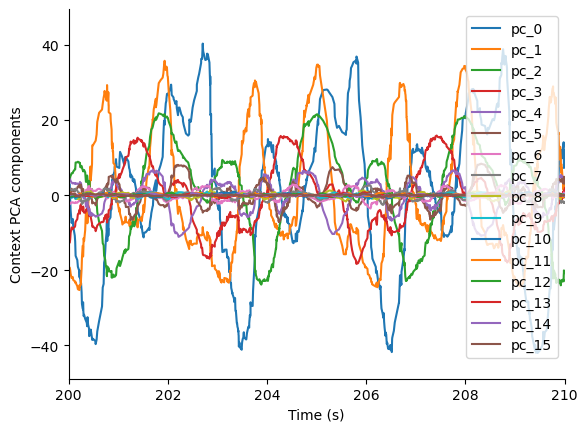

In [9]:
# example context trace
for i in range(context_dim):
    plt.plot(
        analysis.t,
        analysis.c_pca[:, i],
        label=f"pc_{i}",
    )
plt.legend(loc=1)
plt.xlabel("Time (s)")
plt.ylabel("Context PCA components")
plt.xlim(200, 210)
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Context-phase relationship

NameError: name 'l1_penalty' is not defined

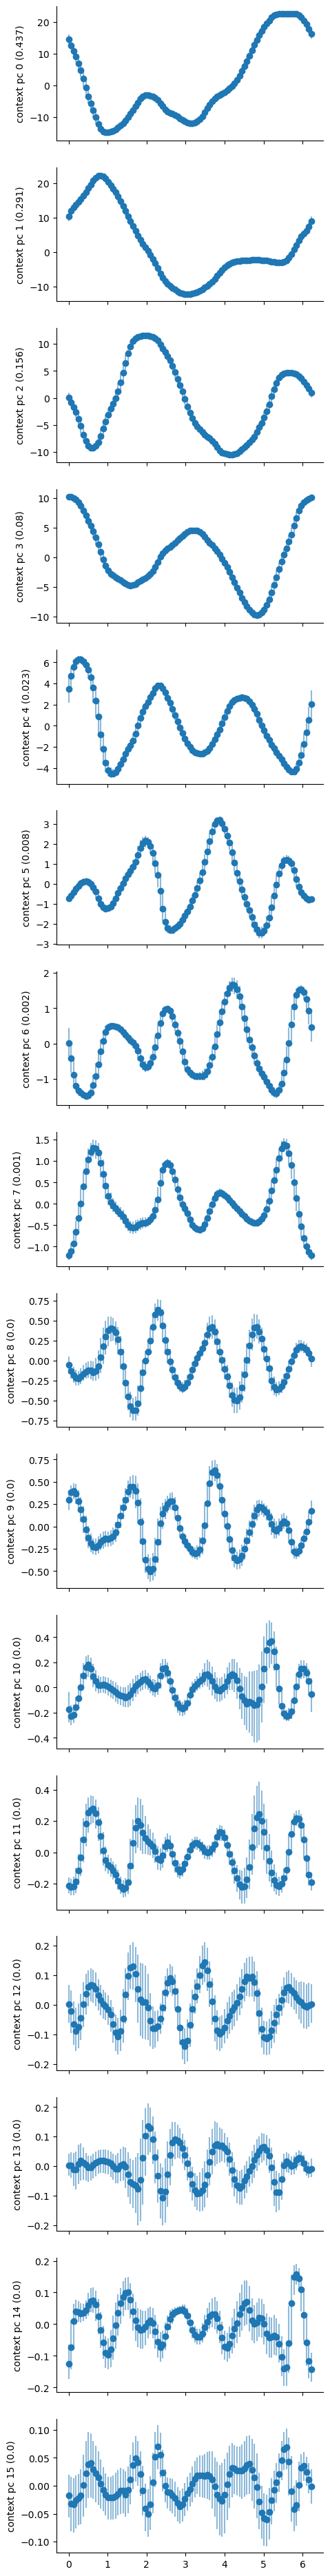

In [16]:
c_binned, bins = analysis.bin_context_by_feature(
    theta, t, pca=True, bins=np.linspace(0, 2 * np.pi, 100)
)

fig, ax = plt.subplots(
    nrows=context_dim, ncols=1, figsize=(5, 3 * context_dim), sharex=True
)

for i in range(context_dim):
    mid = np.array([np.median(cc[:, i]) for cc in c_binned])
    peak_ind = np.argmax(np.abs(mid))
    peak_sign = np.sign(mid[peak_ind])
    mid = mid * peak_sign
    ax[i].scatter(bins[:-1], mid)
    lo = [np.percentile(cc[:, i] * peak_sign, 25) for cc in c_binned]
    hi = [np.percentile(cc[:, i] * peak_sign, 75) for cc in c_binned]
    ax[i].vlines(bins[:-1], lo, hi, color="C0", alpha=0.5)
    ax[i].set_ylabel(
        f"context pc {i} ({np.round(analysis.pca.explained_variance_ratio_[i],3)})"
    )
    ax[i].spines[["top", "right"]].set_visible(False)

fig.suptitle(f"L1(ish) penalty: {l1_penalty}")
plt.xlabel("Latent phase (rad)")

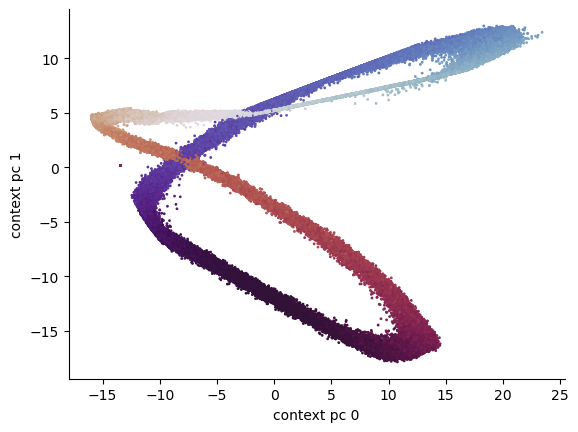

In [31]:
# Context embedding
subset = 3
mark_phase_ind = np.digitize(analysis.t, t) - 1
mark_phase = theta[mark_phase_ind]
plt.scatter(
    analysis.c_pca[::subset, 0],
    analysis.c_pca[::subset, 1],
    c=mark_phase[::subset],
    s=1,
    cmap="twilight",
)
plt.xlabel("context pc 0")
plt.ylabel("context pc 1")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Waveform embedding (Codes for tuning information, NOT waveform voltages)

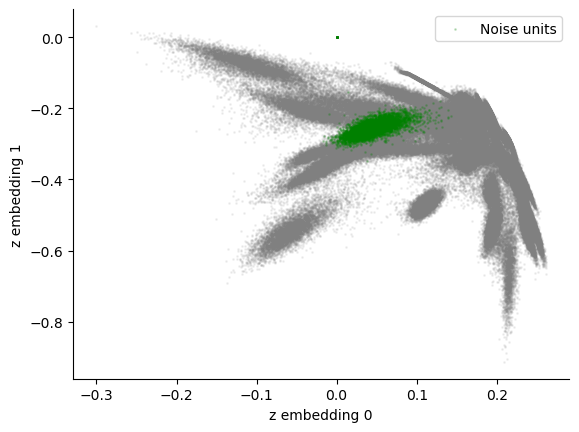

In [133]:
z = analysis.z.copy()
subset = 2

from sklearn.decomposition import PCA

pca = PCA(n_components=latent_dim)
pca.fit(z)
# pca = analysis.pca
# z = pca.transform(z)

ids = mark_ids[1:]
# feature = template_waveforms[ids].argmax(axis=1)
plt.scatter(
    z[::subset, 0], z[::subset, 1], s=1, alpha=0.1, c="grey"
)  # c=feature, cmap="jet")

ind_noise = np.where(ids >= mark_ids.max() - n_noise_units)[0][::subset]
plt.scatter(
    z[ind_noise, 0], z[ind_noise, 1], s=1, alpha=0.2, c="green", label="Noise units"
)
# plt.colorbar(label="Channel of max amplitude")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")
plt.legend(loc=1)
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

# plt.title("Waveform Embedding NOT organized by waveform shape")

Text(0.5, 1.0, 'Waveform Embedding NOT organized by waveform shape')

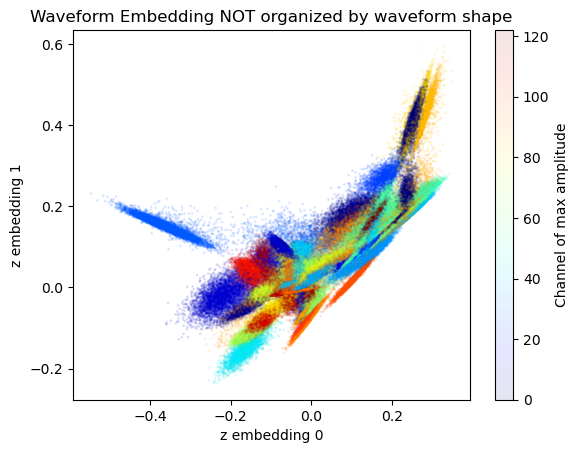

In [50]:
z = analysis.z
# z = pca.transform(z)
ids = mark_ids[1:]
feature = template_waveforms[ids].argmax(axis=1)[::subset]
plt.scatter(z[::subset, 0], z[::subset, 1], s=1, alpha=0.1, c=feature, cmap="jet")
plt.colorbar(label="Channel of max amplitude")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding NOT organized by waveform shape")

Text(0.5, 1.0, 'Waveform Embedding IS organized by tuning features')

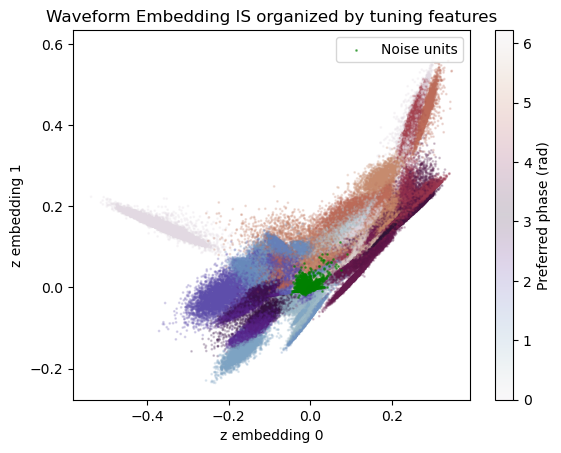

In [ ]:
n_noise_units = 0
ids = mark_ids[1:]

ind = np.where(ids < mark_ids.max() - n_noise_units)[0][::subset]
feature = theta_bins[np.argmax(tuning_curves[:, ids], axis=0)]

ind = np.where(ids < mark_ids.max() - n_noise_units)[0][::subset]
plt.scatter(z[ind, 0], z[ind, 1], s=1, alpha=0.2, c=feature[ind], cmap="twilight")
plt.colorbar(label="Preferred phase (rad)")

ind = np.where(ids >= mark_ids.max() - n_noise_units)[0]
plt.scatter(z[ind, 0], z[ind, 1], s=1, alpha=0.5, c="green", label="Noise units")
plt.legend(loc=1)


plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding IS organized by tuning features")

In [ ]:
i = 13  # example neuron

# Find neuron with similar tuning curve
peak = tuning_curves[:, i].argmax()
target_peak = peak + 0.5
i_tuning = np.argmin((tuning_curves[:,].argmax() - target_peak) ** 2)

# Find neuron with similar waveform
peak = np.argmax(template_waveforms[i])
target_peak = peak + 10
i_waveform = np.argmin((template_waveforms.argmax(axis=1) - target_peak) ** 2)

samples = [i, i_tuning, i_waveform, n_units - 10]

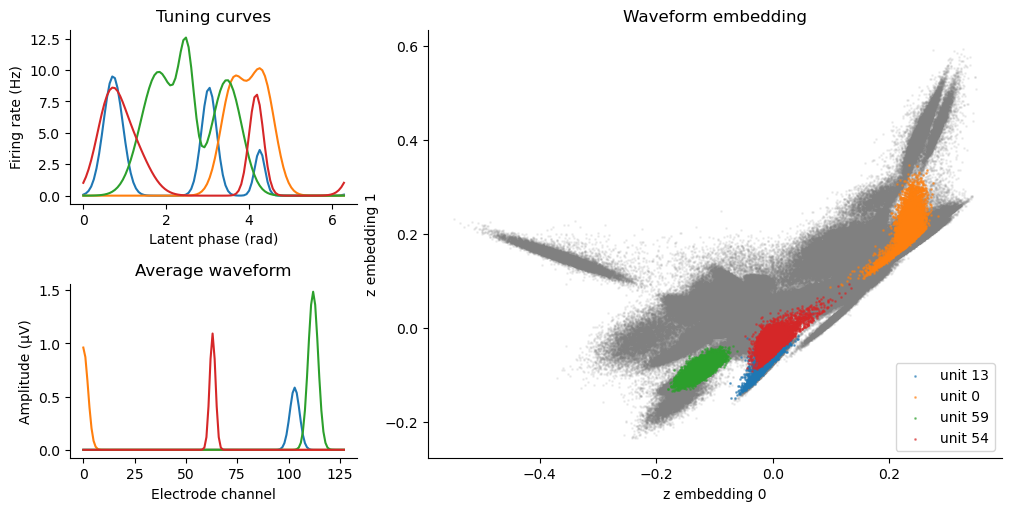

In [53]:
from matplotlib.gridspec import GridSpec
from src.c3po.toy_model_generators.phase import gaussian

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = GridSpec(2, 3, figure=fig)
tuning_ax = fig.add_subplot(gs[0, 0])
waveform_ax = fig.add_subplot(gs[1, 0])
embedding_ax = fig.add_subplot(gs[:, 1:])

for i_ in samples:
    # theta_bins = np.linspace(0, 2 * np.pi, 100)
    tuning_curve_i = tuning_curves[:, i_]
    if i_ >= n_units - n_noise_units:
        rate = np.where(ids == i_)[0].shape[0] / (t_max)
        tuning_curve_i = np.ones_like(tuning_curve_i) * rate

    tuning_ax.plot(theta_bins, tuning_curve_i)

    waveform_ax.plot(
        template_waveforms[i_].T,
    )

z = analysis.z
ids = mark_ids[1:]
embedding_ax.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1, c="grey")
for i_, c_ in zip(samples, ["C0", "C1", "C2", "C3"]):
    embedding_ax.scatter(
        z[ids == i_, 0],
        z[ids == i_, 1],
        s=1,
        alpha=0.5,
        c=c_,
        label=f"unit {i_}{' (noise)' if i_ >= n_units - n_noise_units else ''}",
    )

tuning_ax.set_xlabel("Latent phase (rad)")
tuning_ax.set_ylabel("Firing rate (Hz)")
tuning_ax.spines[["top", "right"]].set_visible(False)
tuning_ax.set_title("Tuning curves")

waveform_ax.set_xlabel("Electrode channel")
waveform_ax.set_ylabel("Amplitude (µV)")
waveform_ax.spines[["top", "right"]].set_visible(False)
waveform_ax.set_title("Average waveform")

embedding_ax.set_xlabel("z embedding 0")
embedding_ax.set_ylabel("z embedding 1")
embedding_ax.spines[["top", "right"]].set_visible(False)
embedding_ax.set_title("Waveform embedding")
embedding_ax.legend(loc=4)

In [ ]:
c_binned, bins = analysis.bin_context_by_feature(theta, t, bins=theta_bins, pca=False)

In [ ]:
bases = np.array([np.mean(c, axis=0) for c in c_binned])

In [136]:
tests = []

In [ ]:
i = 5

ind = np.where(mark_ids[1:] == i)[0]
z_unit = analysis.z[ind]

z_unit = np.mean(z_unit, axis=0)
z_unit = analysis.pca.transform(z_unit[None, :])[0]
print(z_unit[0])
bases.shape, z_unit.shape

predicted_field = (bases * z_unit[None, :]).sum(axis=1)
tests.append(predicted_field)
plt.plot(predicted_field / predicted_field.max())
plt.plot(tuning_curves[:, i] / tuning_curves[:, i].max())
plt.xlabel("Latent phase (rad)")

ValueError: X has 16 features, but PCA is expecting 3 features as input.

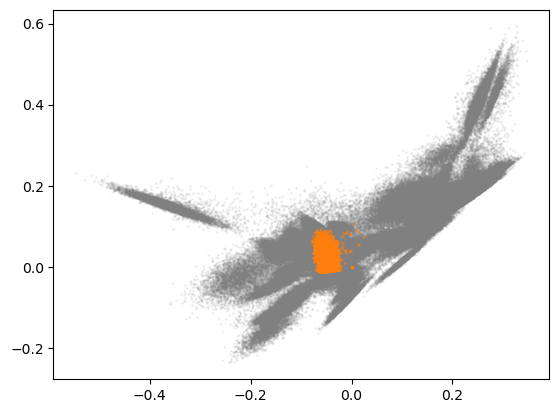

In [ ]:
plt.scatter(analysis.z[::subset, 0], analysis.z[::subset, 1], s=1, alpha=0.1, c="grey")
plt.scatter(z[ind, 0], z[ind, 1], s=1, alpha=0.5, c="C1", label=f"unit {i}")

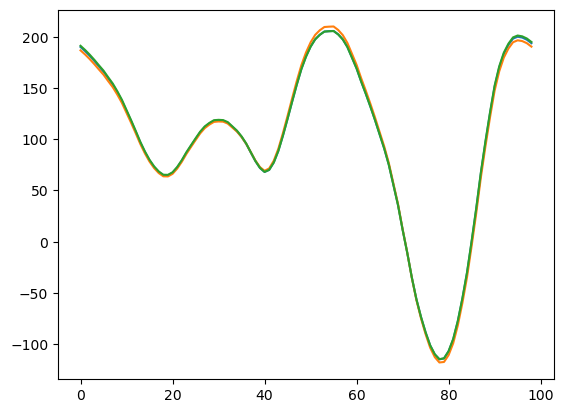

In [94]:
plt.plot(np.array(tests).T)

# Rate Prediction

## Single neuron

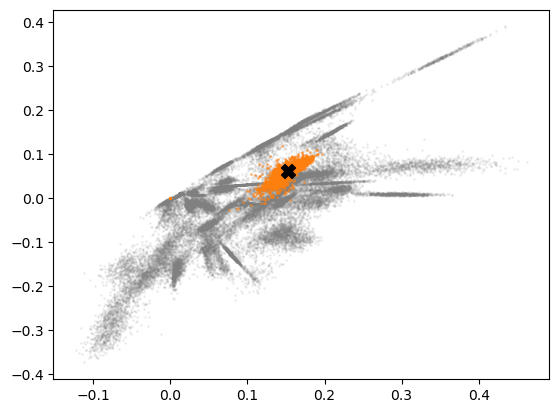

In [54]:
i_neuron = 12
# i_neuron=18
i_neuron = 2
ind = np.where(mark_ids[1:] == i_neuron)[0]
z_unit = analysis.z[ind]
avg_z_unit = np.mean(z_unit, axis=0)

subset = 10
plt.scatter(analysis.z[::subset, 0], analysis.z[::subset, 1], s=1, alpha=0.1, c="grey")
plt.scatter(
    z_unit[:, 0], z_unit[:, 1], s=1, alpha=0.5, c="C1", label=f"unit {i_neuron}"
)
plt.scatter(avg_z_unit[0], avg_z_unit[1], s=100, c="k", marker="X")

In [55]:
rate_params = {"params": params["params"]["rate_prediction"]}

from src.c3po.model.rate_prediction import rate_prediction_factory

rate_model = rate_prediction_factory(
    **rate_args, latent_dim=latent_dim, context_dim=context_dim, n_params=1
)

log_pred_rate = rate_model.apply(
    rate_params,
    np.repeat(avg_z_unit[None, :], analysis.c_interp.shape[0], axis=0),
    analysis.c_interp,
)
log_pred_rate_full = rate_model.apply(
    rate_params,
    np.repeat(avg_z_unit[None, :], analysis.c.shape[0], axis=0),
    analysis.c,
)

tuning_curve_i = tuning_curves[:, i_neuron]
theta_index = np.digitize(theta, bins=theta_bins) - 1
nominal_rate = tuning_curve_i[theta_index]
ind = np.where(mark_ids[1:] == i_neuron)[0]
observed_spike_times = analysis.t[ind]

t_observed = np.arange(0, t_max, 0.01)
binned_spike_counts = np.histogram(observed_spike_times, bins=t_observed)[0]
binned_spike_counts = smooth(binned_spike_counts, n=30, sigma=10) * 100

Text(0.5, 1.0, 'Neuron 2 firing rate prediction')

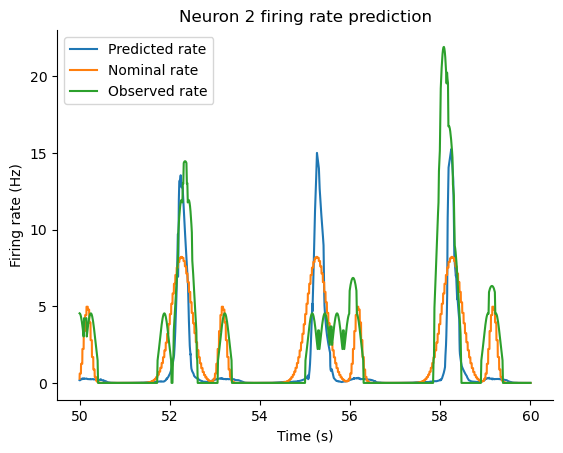

In [56]:
t_rng = (50, 60)


ind_interp = np.where(
    (analysis.t_interp >= t_rng[0]) & (analysis.t_interp <= t_rng[1])
)[0]
plt.plot(
    analysis.t_interp[ind_interp],
    np.exp(log_pred_rate[ind_interp]),
    label="Predicted rate",
)

ind_theta = np.where((t >= t_rng[0]) & (t <= t_rng[1]))[0]
plt.plot(
    t[ind_theta],
    nominal_rate[ind_theta],
    label="Nominal rate",
)

ind_observed = np.where((t_observed[:-1] >= t_rng[0]) & (t_observed[:-1] <= t_rng[1]))[
    0
]
plt.plot(
    t_observed[:-1][ind_observed],
    binned_spike_counts[ind_observed],
    label="Observed rate",
)
# plt.plot(analysis.t_interp[ind_interp], nominal_rate[ind_interp], label="Nominal rate")
# plt.plot(analysis.t_interp[ind_interp], binned_spike_counts[ind_interp], label="Observed rate")
plt.legend()
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.xlabel("Time (s)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"Neuron {i_neuron} firing rate prediction")

In [ ]:
def integrated_rate(nominal_rate, t_rate, t_start, t_end):
    """Integrate rate between t_start and t_end"""
    ind_st = np.searchsorted(t_rate, t_start)
    ind_end = np.searchsorted(t_rate, t_end)

    if ind_st == ind_end:
        return nominal_rate[ind_st] * (t_end - t_start)
    first_bin_contrib = nominal_rate[ind_st] * (t_rate[ind_st + 1] - t_start)
    last_bin_contrib = nominal_rate[ind_end] * (t_end - t_rate[ind_end])
    if ind_end - ind_st == 1:
        return first_bin_contrib + last_bin_contrib
    ind = slice(ind_st + 1, ind_end)
    return (
        np.sum(nominal_rate[ind]) * np.mean(np.diff(t_rate))
        + first_bin_contrib
        + last_bin_contrib
    )


test_spikes = observed_spike_times[1000:2000]

pred_rate = np.exp(log_pred_rate)
norm_delays = []
for i in range(1, len(test_spikes)):
    rate_int = integrated_rate(
        pred_rate,
        analysis.t_interp,
        test_spikes[i - 1],
        test_spikes[i],
    )
    norm_delays.append(rate_int)

KeyboardInterrupt: 

## KS Goodness of Fit

In [57]:
import numpy as np
from numpy.typing import NDArray


def integrated_rate_vec(
    nominal_rate: NDArray[np.floating],
    t_rate: NDArray[np.floating],
    t_start: NDArray[np.floating],
    t_end: NDArray[np.floating],
) -> NDArray[np.floating]:
    """Vectorized integral of a piecewise-constant rate over many [t_start, t_end] intervals.

    The rate is assumed piecewise-constant: nominal_rate[i] is used on the half-open
    interval [t_rate[i], t_rate[i + 1]). Works with non-uniform bin widths.

    Parameters
    ----------
    nominal_rate : ndarray, shape (n_grid,)
        Piecewise-constant rate values indexed by bin start.
        The value at index i applies on [t_rate[i], t_rate[i + 1]).
        The last element is allowed; it will only be multiplied by zero if t_end == t_rate[-1].
    t_rate : ndarray, shape (n_grid,)
        Monotonically increasing grid of bin edges (length must match nominal_rate).
    t_start : ndarray, shape (n_intervals,)
        Start times of integration intervals.
    t_end : ndarray, shape (n_intervals,)
        End times of integration intervals (must satisfy t_end >= t_start elementwise).

    Returns
    -------
    ndarray, shape (n_intervals,)
        Integral of the rate over each [t_start[k], t_end[k]].

    Notes
    -----
    This is the vectorized analogue of calling the scalar routine per interval, but uses
    a cumulative integral to account for any number of full bins between the first and last
    partial bins without Python loops.
    """
    # Indices of the bins containing starts/ends (left insertion => bin start index)
    i = np.searchsorted(t_rate, t_start, side="left")
    j = np.searchsorted(t_rate, t_end, side="left")

    # Bin widths and per-bin integrals for non-uniform grids
    dt = np.diff(t_rate)  # shape (n_grid-1,)
    bin_int = nominal_rate[:-1] * dt  # integral over each full bin
    # Cumulative integral up to edge k: cum[k] = ∑_{b=0}^{k-1} nominal_rate[b] * (t_rate[b+1]-t_rate[b])
    cum = np.concatenate(([0.0], np.cumsum(bin_int)))  # shape (n_grid,)

    # First partial bin: from t_start to min(t_rate[i+1], t_end)
    # Safe to index i+1 because t_start must be < t_rate[-1] in valid usage.
    first_bin_end = t_rate[i + 1]
    first = nominal_rate[i] * (np.minimum(first_bin_end, t_end) - t_start)

    # Full bins strictly between first and last: bins [i+1, j-1]
    # Only present if j - i >= 2
    has_full = (j - i) >= 2
    full_between = np.where(has_full, cum[j] - cum[i + 1], 0.0)

    # Last partial bin: from max(t_rate[j], t_start) to t_end, only if j > i
    last = np.where(j > i, nominal_rate[j] * (t_end - t_rate[j]), 0.0)

    return first + full_between + last


# test_spikes = observed_spike_times[:]

# norm_delays = integrated_rate_vec(
#     np.squeeze(np.exp(log_pred_rate_full)),
#     analysis.t,
#     test_spikes[:-1],
#     test_spikes[1:],
# )

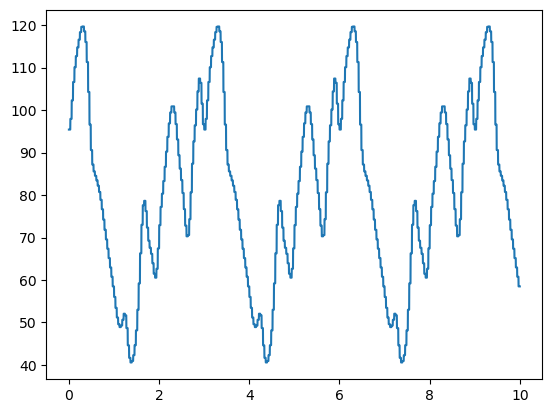

In [58]:
# nominal MUA rate
mua_tuning_curve = tuning_curves.sum(axis=1)
theta_index = np.digitize(theta, bins=theta_bins) - 1
nominal_mua_rate = mua_tuning_curve[theta_index]
t_mua_rate = t
plt.plot(t[:10000], nominal_mua_rate[:10000])

In [59]:
from src.c3po.model.rate_prediction import rate_prediction_factory
from tqdm import tqdm

rate_model = rate_prediction_factory(
    **rate_args, latent_dim=latent_dim, context_dim=context_dim, n_params=1
)

mean_rate = analysis.t.size / analysis.t[-1]

nominal_mua_multiplier = np.interp(analysis.t, t_mua_rate, nominal_mua_rate) / n_units

norm_delays = []
for i_neuron in tqdm(range(n_units)):
    ind = np.where(mark_ids[1:] == i_neuron)[0]
    spike_times = analysis.t[ind]
    z_unit = analysis.z[ind]
    avg_z_unit = np.mean(z_unit, axis=0)
    rate_params = {"params": params["params"]["rate_prediction"]}

    log_pred_rate = rate_model.apply(
        rate_params,
        np.repeat(avg_z_unit[None, :], analysis.c.shape[0], axis=0),
        analysis.c,
    )
    pred_rate = np.squeeze(
        np.exp(log_pred_rate)
    )  # * np.squeeze(nominal_mua_multiplier)
    norm_delays_ = integrated_rate_vec(
        np.squeeze(pred_rate),
        analysis.t,
        spike_times[:-1],
        spike_times[1:],
    )
    norm_delays.append(norm_delays_)
    # uniform_norm_delays = 1 - np.exp(-np.array(norm_delays))

100%|██████████| 64/64 [00:04<00:00, 13.29it/s]


0.6250444096308095
0.8855670549927337
0.7783085629202733
0.11896201996019512
0.0
0.20328934846241653
0.593494153083731
0.15583422613769737
0.6910021442863024
0.36498926820665106
0.5652921945463206
0.6666119011743951
0.37196021074858554
1.0
1.0
0.6983642548182518
0.0
0.6654120393705567
0.6889486751144033
0.38733489785433506
0.611535080300293
0.41032586995632203
0.38679140751372976
0.0
0.3358283936311591
0.0
0.7122611231878391
0.8093082813416739
0.3571009917566893
0.0
0.63859305756952
0.09593940125726685
0.5879618484343287
0.17795752985197183
0.0
1.0
0.0
0.4565680477109489
0.0
0.26956677616759905
0.5495203034458797
0.7287776607898907
0.5464766385064221
0.24632956126784872
0.971406463792492
0.2730762137509152
0.0003720480015730332
0.7740303772768692
0.7762518628175221
0.7881154941167202
0.2506105680195607
0.37320785739074025
0.042763410671099955
0.4232341953409562
0.7666826640696416
0.21735047209655622
0.8920055826762258
0.600502019381068
0.41543857710195714
0.4352804278381982
0.0
0.65695

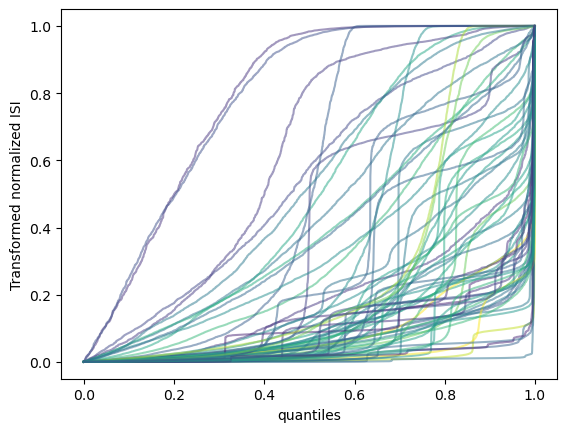

In [61]:
n_spikes = [len(nd) for nd in norm_delays]
mean_rates = [len(nd) / t_max for nd in norm_delays]
mean_rate = np.mean(mean_rates)

# mean_norm_delay = np.mean(np.concatenate(norm_delays))
mean_norm_delay = np.mean([np.mean(nd) for nd in norm_delays if len(nd) > 0])

clip_color = 1
for i_neuron, nd in enumerate(norm_delays):
    # nd_norm = nd / mean_norm_delay
    nd_norm = nd
    # nd_norm = nd / np.mean(nd)
    uniform_norm_delays = 1 - np.exp(-np.array(nd_norm))
    # uniform_norm_delays = 1 - np.exp(-np.array(nd))
    uniform_norm_delays = np.sort(uniform_norm_delays)
    n = len(uniform_norm_delays)
    # rel_color_val = np.log2(n_spikes[i_neuron] + 1) - np.log2(max(n_spikes) + 1)
    rel_color_val = mean_rates[i_neuron] / mean_rate
    rel_color_val = np.log2(rel_color_val)
    rel_color_val = (
        np.clip(rel_color_val, -clip_color, clip_color) / clip_color / 2 + 0.5
    )
    print(rel_color_val)
    plt.plot(
        np.arange(n) / n,
        uniform_norm_delays,
        label=f"Neuron {i_neuron}",
        # color = "cornflowerblue",
        alpha=0.5,
        color=plt.cm.viridis(n_spikes[i_neuron] / max(n_spikes)),
        # color = plt.cm.RdBu(rel_color_val),
        # clim=(-3, 3)
    )
    plt.xlabel("quantiles")
    plt.ylabel("Transformed normalized ISI")

In [34]:
[np.mean(nd) for nd in norm_delays if len(nd) > 0]

[1.9343057539066706,
 0.36390230178189076,
 8.235623880403866,
 0.5839372069730152,
 47.74928568030027,
 5.3345020531337175,
 0.24336495771785,
 0.5288690586501967,
 0.07177495202023873,
 0.43698715104568425,
 2.2860287260328827,
 0.3314346246998859,
 0.1137246539640745,
 0.07279524036779199,
 0.07230265228296165,
 11.33508783920548,
 0.2733504426344654,
 0.17568005787885219,
 0.109101357561732,
 0.0706420329590723,
 0.627120159986977,
 0.5629257164114922,
 0.9662537037728989,
 0.6594921586480341,
 10.18185461015786,
 0.8934210272011064,
 1.712217823185478,
 0.13238207571209532,
 0.07573855217777174,
 3.025591224812342,
 6.54132602515504,
 0.7298074416263083,
 0.07668369988453559,
 3.130113302185948,
 0.3912806733472373,
 0.09409246660777235,
 0.49546265847376514,
 0.2811045314140604,
 0.7088741590731313,
 0.137801502350353,
 0.37157216158323975,
 0.11833194192293293,
 0.44832890292120414,
 0.3278375523452175,
 1.278504630413976,
 0.45518269617582585,
 0.7272934164585458,
 0.2133311425

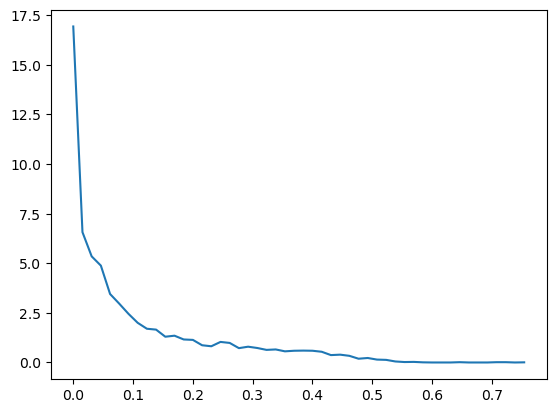

In [ ]:
c_, b_ = np.histogram(np.squeeze(1 - np.exp(-norm_delays)), bins=50, density=True)

plt.plot(b_[:-1], c_)
# plt.yscale("log")
# plt.xscale("log")
# plt.xlim(1e-2, 2)

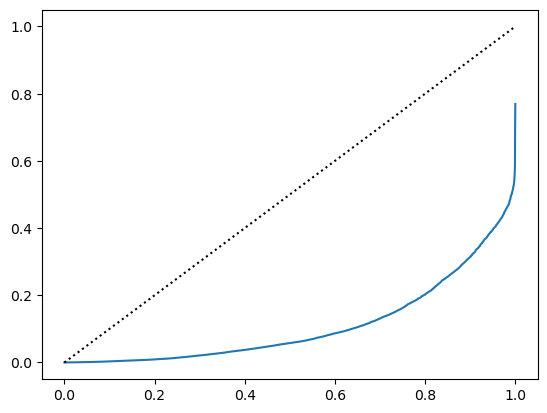

In [ ]:
unif_norm_delays = np.squeeze(1 - np.exp(-norm_delays))
uniform_norm_delays = np.sort(unif_norm_delays)

expected_cdf = np.linspace(0, 1, len(uniform_norm_delays))
plt.plot(
    expected_cdf,
    uniform_norm_delays,
)
plt.plot(expected_cdf, expected_cdf, ls=":", c="k")

(0.01, 2)

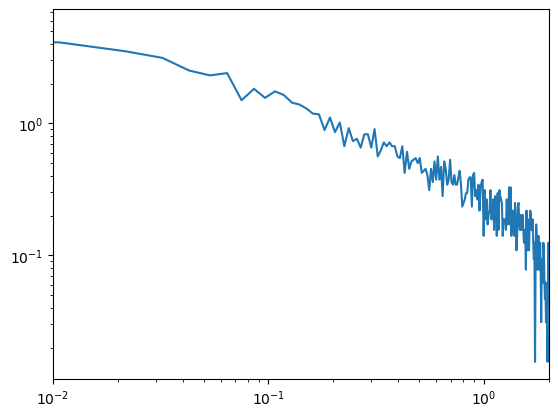

In [ ]:
c_, b_ = np.histogram(np.squeeze(norm_delays), bins=500, density=True)

plt.plot(b_[:-1], c_)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-2, 2)

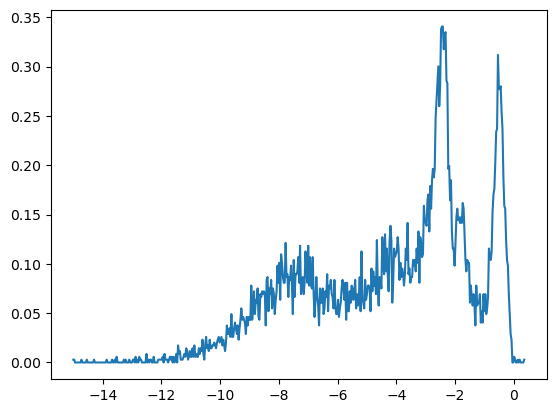

In [76]:
c_, b_ = np.histogram(np.log(np.squeeze(norm_delays)), bins=500, density=True)

plt.plot(b_[:-1], c_)
# plt.yscale("log")
# plt.xscale("log")
# # plt.xlim(1e-2, 2)